In [1]:
#!rm -r AI2022MA/
#!git clone https://github.com/UmbertoJr/AI2022MA.git

# The Orienteering Problem with Time Windows

column of X:

0. index of the customer
1. x coordinate
2. y coordinate
3. lower time window
4. uppper time window
5. reward customer
6. global time constraint

adj is the distance matrix

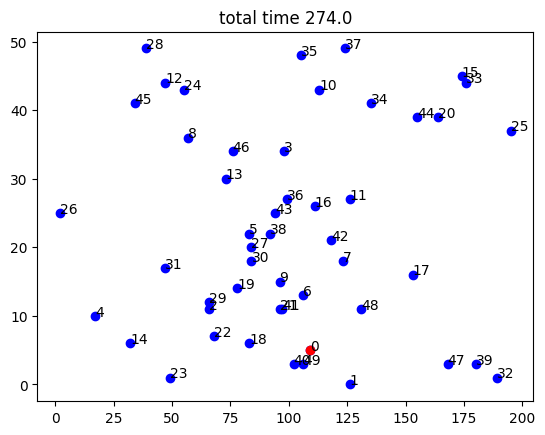

[[0.000e+00 1.090e+02 5.000e+00 0.000e+00 1.312e+03 0.000e+00 2.740e+02]
 [1.000e+00 1.260e+02 0.000e+00 2.130e+02 2.320e+02 1.700e-01 2.740e+02]
 [2.000e+00 6.600e+01 1.100e+01 7.320e+02 7.380e+02 4.000e-01 2.740e+02]
 [3.000e+00 9.800e+01 3.400e+01 1.310e+02 1.690e+02 2.900e-01 2.740e+02]
 [4.000e+00 1.700e+01 1.000e+01 6.390e+02 6.740e+02 8.400e-01 2.740e+02]]
(50, 7)
(50, 50)


In [2]:
import numpy as np
from AI2022MA.OPTW import Env, plot_instance

env = Env(from_file=True, instance_number=0)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

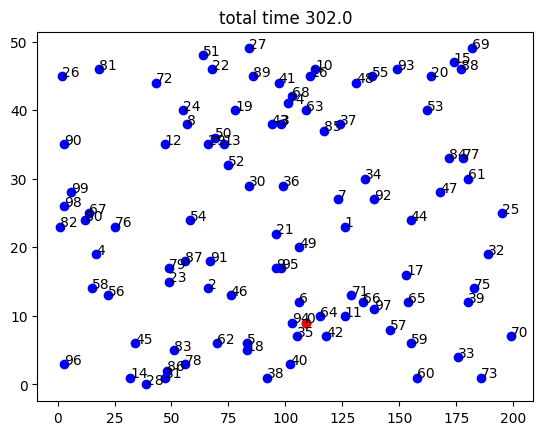

[[0.000e+00 1.090e+02 9.000e+00 0.000e+00 1.857e+03 0.000e+00 3.020e+02]
 [1.000e+00 1.260e+02 2.300e+01 2.060e+02 2.250e+02 2.000e-01 3.020e+02]
 [2.000e+00 6.600e+01 1.400e+01 4.000e+01 7.100e+01 3.800e-01 3.020e+02]
 [3.000e+00 9.800e+01 3.800e+01 1.170e+02 1.490e+02 2.800e-01 3.020e+02]
 [4.000e+00 1.700e+01 1.900e+01 6.430e+02 6.700e+02 8.200e-01 3.020e+02]]
(100, 7)
(100, 100)


In [3]:
env = Env(from_file=True, instance_number=1)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

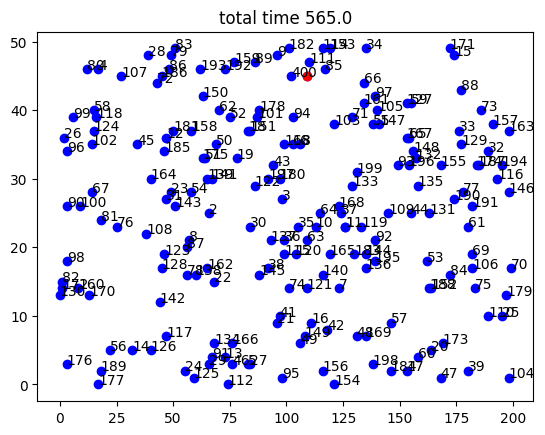

[[0.000e+00 1.090e+02 4.500e+01 0.000e+00 2.486e+03 0.000e+00 5.650e+02]
 [1.000e+00 1.260e+02 2.300e+01 1.410e+02 1.780e+02 2.500e-01 5.650e+02]
 [2.000e+00 6.600e+01 2.500e+01 8.880e+02 9.420e+02 4.100e-01 5.650e+02]
 [3.000e+00 9.800e+01 2.700e+01 2.400e+01 7.100e+01 1.900e-01 5.650e+02]
 [4.000e+00 1.700e+01 4.600e+01 6.880e+02 7.030e+02 8.000e-01 5.650e+02]]
(200, 7)
(200, 200)


In [4]:
env = Env(from_file=True, instance_number=2)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

### check if solution is feasible and print it

time window violated 225.0 
current time  233.0 
from node 1  to  49
(233.0, 0, False)


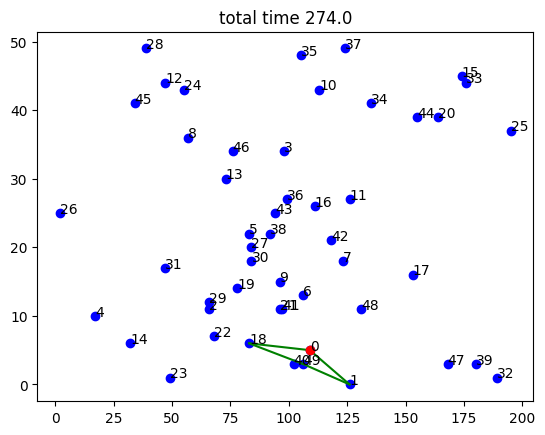

In [5]:
sol = [0, 1, 49, 18, 0]
env = Env(from_file=True, instance_number=0, verbose=True)
print(env.check_solution(sol))
plot_instance(env.x, sol)

(236.0, 0.44999999999999996, True)


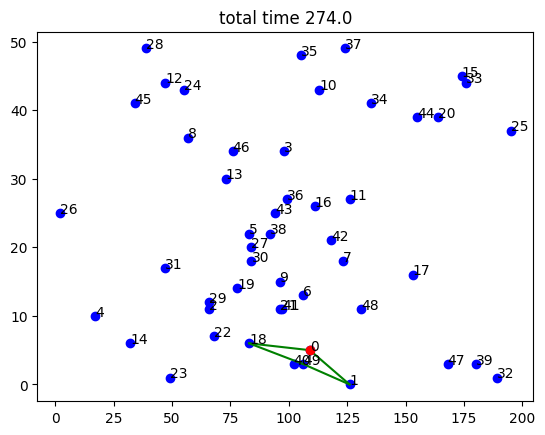

In [6]:
sol = [0, 18, 49, 1, 0]
env = Env(from_file=True, instance_number=0, verbose=True)
print(env.check_solution(sol))
plot_instance(env.x, sol)

# Monte Carlo Tree Search

### Node class for the Tree Search


In [13]:
### Node Object ###
class Node:
    def __init__(self, parent, node, travel_time, partial_path, current_reward, expandable_customers):
      self.parent = parent                                                      # parent node object 
      self.node = node                                                          # current node (or customer) index
      self.partial_path = partial_path                                          # current partial path across customers
      self.current_reward = current_reward                                      # current reward collected in the partial path
      self.num_of_visit = 0                                                     # number of visit to the current node during the MCTS 
      self.terminal = False                                                     # boolean to determine if node is terminal
      self.fully_expanded = False                                               # boolean to determine if node was expanded completely during the search
      self.estimated_reward = 0                                                 # esteem of the future reward collected thanks to the MC simulations
      self.travel_time = travel_time                                            # travel time spent with the current partial path
      self.score = None                                                         # Upper Confidence Buond score for node
      self.policy = None                                                        # IMPORTANT !!!!! Best node index according to the UCB score 
      self.expandables = copy.deepcopy(expandable_customers)                    # customers in the candidate list of the current node that are not in the current path
      self.expanded = {}
      self.reward = 0# nodes already expanded during the search
      
      if len(self.expandables) == 0:                                            
        self.fully_expanded = True
        self.terminal = True
        self.partial_path.append(0)
        self.policy = 0

    def calculateUCTscore(self, best_reward_so_far):
      # computes the Upper Confidence Bound for the Node
      c = 1 / (2 ** 0.5)
      self.score = (((self.estimated_reward/ self.num_of_visit) + self.current_reward) /
                    best_reward_so_far) + c * 2 * (2 * np.log(self.parent.num_of_visit) / 
                                                   self.num_of_visit) ** 0.5


### MCTS

In [32]:
from time import time
import copy
import numpy as np
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
import math

class MCTS:
  def __init__(self, env,time_limit, initial_path):
    self.num_of_customers = env.n_nodes                                         # number of customers in the current problem
    self.env = env                                                              # environment of the problem to solve
    self.time_limit = time_limit                                                # time budget for the OPTW to solve
    self.initial_path = initial_path                                            # initial path
    self.root_node = initial_path[-1]                                           # root node index

    # saving the best tour so far, its reward and time travel
    self.best_tour_so_far = initial_path + [0]
    travel_time, self.max_reward, _ = self.env.check_solution(self.best_tour_so_far)

    # these operations find the promising CL for the root node
    ordered_view = {i: self.env.x[i, 5] / (self.env.x[i, 3] / self.env.x[i, 6]) for i in range(1, self.num_of_customers) if i not in initial_path 
                    and self.env.adj[self.root_node, i] + travel_time < self.env.x[i, 4]
                    and self.env.adj[i, 0] + self.env.adj[self.root_node, i] + travel_time < self.env.x[i, 6]}
    ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: item[1]) if k not in initial_path]

    # initialize the root node
    self.root = Node(parent=None,
                     node= self.root_node,
                     travel_time =travel_time,
                     partial_path=initial_path,
                     current_reward=0, 
                     expandable_customers=ordered_list)


  def treePolicy(self, node):
    """
    This function expand a node if the selected node is not being completely expanded,
    otherwise it select the best child in the Tree using the selectBestChild function
    """
    # TO DO
    # implement the tree policy
    while not node.terminal:
        if not node.fully_expanded:
            return self.expand(node)
        else:
            node = self.selectBestChild(node)
    return node
    

  def selectBestChild(self, node):
    """
    The function updates the UBC score for each child node by employing the updated max_reward
    then it returns the best child according to such score. 
    """
    best_score = 0
    best_child = None
    for index, child in node.expanded.items():
        child.calculateUCTscore(self.max_reward)
        if child.score > best_score:
            best_score = child.score
            best_child = child
            node.policy = index
    return best_child
    


  def expand(self, node):
    new_node = node.expandables.pop()                                           # it selects the most promising node from the CL 
    new_path = copy.deepcopy(node.partial_path)                                 # it copies the path and append new node to it
    new_path.append(new_node)
        
    new_reward = node.current_reward                                            # update of the reward for the new customer
    new_reward += self.env.x[new_node, 5]

    new_travel_time = max(node.travel_time + self.env.adj[node.node, new_node], # updated the travel time
                          self.env.x[new_node, 3])

    # these operations find the promising CL for the root node
    ordered_view = {i: self.env.x[i, 5]/(self.env.x[i, 3] / self.env.x[i, 6]) for i in range(1, self.num_of_customers) if i not in new_path 
                    and self.env.adj[new_node, i] + new_travel_time < self.env.x[i, 4]
                    and self.env.adj[i, 0] + self.env.adj[new_node, i] + new_travel_time < self.env.x[i, 6]}
    ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: item[1]) if k not in new_path]

    new_node_object = Node(parent=node,
                           node=new_node,
                           travel_time=new_travel_time,
                           partial_path=new_path,
                           current_reward=new_reward, 
                           expandable_customers=ordered_list)
    
    node.expanded[new_node] = new_node_object
    if len(node.expandables) == 0:
      node.fully_expanded = True
      
    if new_node == 0:
      new_node_object.terminal = True
      _, new_r, _ = self.env.check_solution(new_path)
      if new_r > self.max_reward:
        self.max_reward = new_r
        self.best_tour_so_far = new_path

    return new_node_object

  def defaultPolicy(self, starting_node):
    # reach the end, break condition
    if starting_node.node == 0:
      return 0

    customer = starting_node.node
    new_path = starting_node.partial_path
    travel_time = starting_node.travel_time
    while customer != 0:
      # these operations find the promising CL for the root node
      ordered_view = {i: (self.env.x[i, 5] + np.finfo(float).eps)/(self.env.x[i, 3] / self.env.x[i, 6] + np.finfo(float).eps ) for i in range(1, self.num_of_customers) if i not in new_path 
                      and self.env.adj[customer, i] + travel_time < self.env.x[i, 4] 
                      and self.env.adj[i, 0] + self.env.adj[customer, i] + travel_time < self.env.x[i, 6]}
      ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: -item[1]) if k not in new_path]
      if len(ordered_list) == 0:
        customer = 0
      else:
        probabilities = softmax(np.array([v for k, v in sorted(ordered_view.items(), key=lambda item: -item[1]) if k not in new_path]))
        customer = int(np.random.choice(ordered_list, 1, p=probabilities))
      
      new_path.append(customer)
      travel_time = max(travel_time + self.env.adj[new_path[-2], customer], self.env.x[customer, 3])
      
    _, new_r, _ = self.env.check_solution(new_path) 
    if new_r > self.max_reward:
        self.max_reward = new_r
        self.best_tour_so_far = new_path

    return new_r - starting_node.current_reward
      

  def backup(self, node, reward_esteem):
    """
    backup of the estimated reward in the MCTS
    """
    # TO DO
    while node is not None:
        node.num_of_visit += 1
        node.reward += reward_esteem
        node = node.parent

    
  

  def step(self, num_of_simulation=1):
    start = time()
    while time() - start < self.time_limit:
        current_node = self.treePolicy(self.root)
        reward_esteem = self.defaultPolicy(current_node)
        self.backup(current_node, reward_esteem)

    return self.root.policy if self.root.policy != None else 0

(901.0, 0, False)


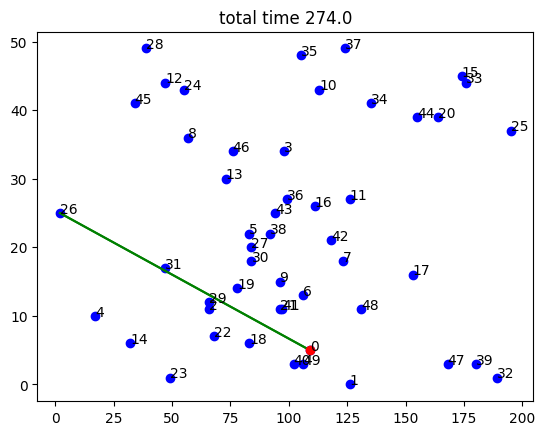

(273.0, 0.44, True)


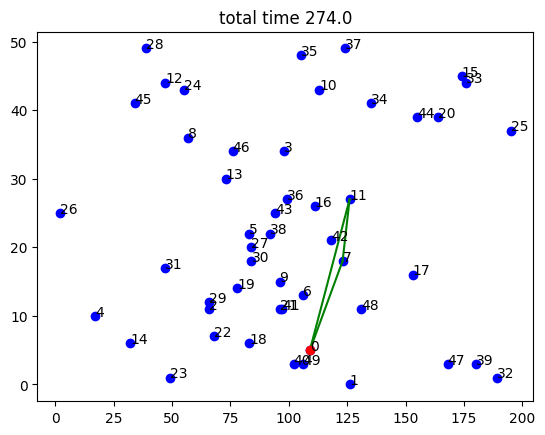

In [37]:
env = Env(from_file=True, instance_number=0)
time_limit = 5
sol = [0]
best_sol = []
best_r = 0

while True:
  mcts = MCTS(env, time_limit, sol)
  mcts.best_tour_so_far = best_sol
  mcts.max_reward = best_r
  new_customer = mcts.step()
  # print("a new customer is", new_customer)
  sol.append(new_customer)
  
  if mcts.max_reward > best_r:
    best_r = mcts.max_reward
    best_sol = mcts.best_tour_so_far
    
  if sol[-1] == 0:
    break

print(env.check_solution(sol))
plot_instance(env.x, sol)
print(env.check_solution(best_sol))
plot_instance(env.x, best_sol)

(787.0, 0, False)


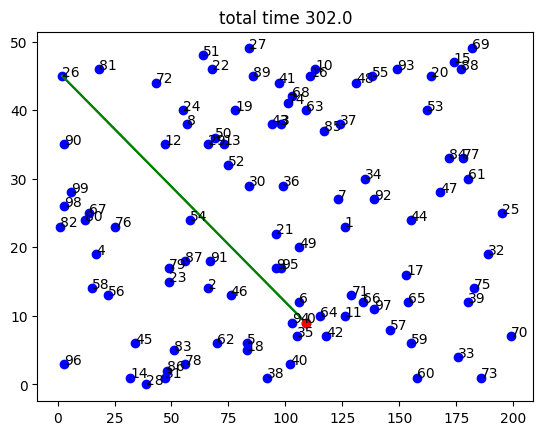

(297.0, 0.43, True)


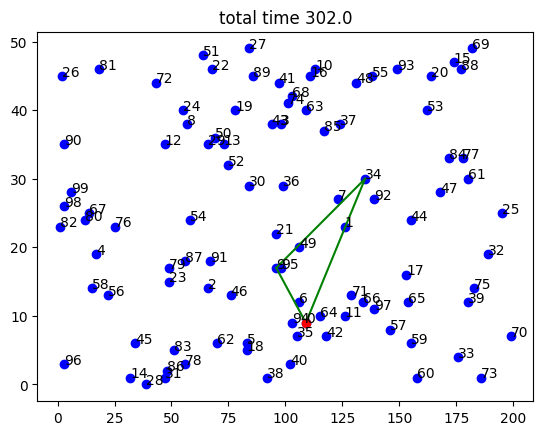

In [34]:
env = Env(from_file=True, instance_number=1)
time_limit = 5
sol = [0]
best_sol = None
best_r = 0
while True:
  mcts = MCTS(env, time_limit, sol)
  mcts.best_tour_so_far = best_sol
  mcts.max_reward = best_r
  new_customer = mcts.step()
  # print("a new customer is", new_customer)
  sol.append(new_customer)
  if mcts.max_reward > best_r:
    best_r = mcts.max_reward
    best_sol = mcts.best_tour_so_far
  if sol[-1] == 0:
    break

print(env.check_solution(sol))
plot_instance(env.x, sol)
print(env.check_solution(best_sol))
plot_instance(env.x, best_sol)

(742.0, 0, False)


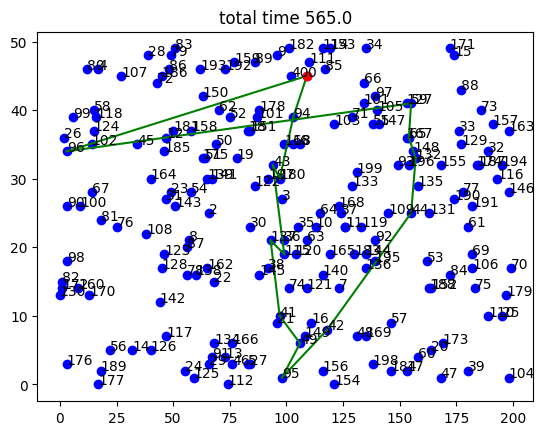

(742.0, 0, False)


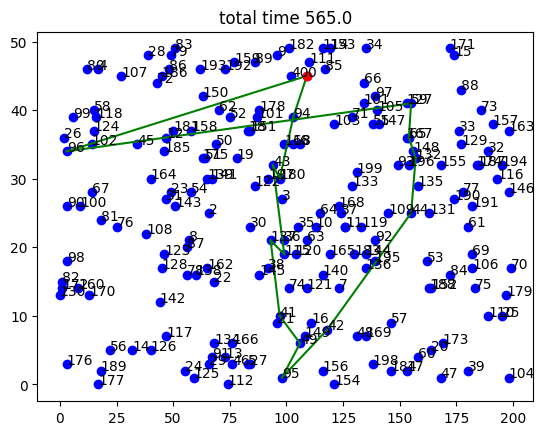

In [41]:
env = Env(from_file=True, instance_number=2)
time_limit = 5
sol = [0]
best_sol = None
best_r = 0
while True:
  mcts = MCTS(env, time_limit, sol)
  mcts.best_tour_so_far = best_sol
  mcts.max_reward = best_r
  new_customer = mcts.step()
  sol.append(new_customer)
  if mcts.max_reward > best_r:
    best_r = mcts.max_reward
    best_sol = mcts.best_tour_so_far
  if sol[-1] == 0:
    break
if best_sol is None:
      best_sol= sol
      
print(env.check_solution(list(sol)))
plot_instance(env.x, list(sol))
print(env.check_solution(list(best_sol)))
plot_instance(env.x, list(best_sol))